<a href="https://colab.research.google.com/github/brodyu/streamflow-forecasting-deep-learning/blob/main/collab_manoa_lstm_bidirectional_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, RepeatVector, TimeDistributed
from keras.utils import np_utils
from keras.layers import Flatten
import seaborn as sns
import joblib
import tensorflow as tf
import keras

In [ ]:
# raw url link from GitHub repo: https://github.com/brodyu/streamflow-forecasting-deep-learning/blob/main/Manoa.csv

# choose reduced data or regular data: reduced Manoa stream due (5 months) due to missing values
# url = "https://raw.githubusercontent.com/brodyu/streamflow-forecasting-deep-learning/main/Manoa.csv"
url = "https://raw.githubusercontent.com/brodyu/streamflow-forecasting-deep-learning/main/Manoa_reduced.csv"
df = pd.read_csv(url)
df.drop('totalSnow_cm', axis=1, inplace=True)
df.drop('moon_illumination', axis=1, inplace=True)
df.head()

,Date,Discharge,dischargeWaiakeakua,dischargeWaihi,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,10/1/2011,2.64,1.67,0.53,34,23,10.2,6,22,31,31,28,9,51,74,1.5,1009,34,9,304,6
1,10/2/2011,2.63,1.67,0.54,32,23,8.8,6,23,30,30,27,5,60,84,4.8,1010,32,5,258,3
2,10/3/2011,2.74,1.65,0.53,34,23,10.2,6,22,30,30,27,7,51,78,11.6,1010,34,7,160,4
3,10/4/2011,5.92,1.95,0.70,37,21,11.6,8,19,30,30,28,6,22,63,0.0,1008,37,8,165,4
4,10/5/2011,2.92,1.80,0.61,35,22,11.6,8,18,31,31,29,6,22,56,0.1,1009,35,10,105,4


In [ ]:
df = df.set_index("Date")
df.head()

,Discharge,dischargeWaiakeakua,dischargeWaihi,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
Date,,,,,,,,,,,,,,,,,,,,
10/1/2011,2.64,1.67,0.53,34,23,10.2,6,22,31,31,28,9,51,74,1.5,1009,34,9,304,6
10/2/2011,2.63,1.67,0.54,32,23,8.8,6,23,30,30,27,5,60,84,4.8,1010,32,5,258,3
10/3/2011,2.74,1.65,0.53,34,23,10.2,6,22,30,30,27,7,51,78,11.6,1010,34,7,160,4
10/4/2011,5.92,1.95,0.70,37,21,11.6,8,19,30,30,28,6,22,63,0.0,1008,37,8,165,4
10/5/2011,2.92,1.80,0.61,35,22,11.6,8,18,31,31,29,6,22,56,0.1,1009,35,10,105,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3105 entries, 10/1/2011 to 3/31/2020
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Discharge            3105 non-null   float64
 1   dischargeWaiakeakua  3105 non-null   float64
 2   dischargeWaihi       3105 non-null   float64
 3   maxtempC             3105 non-null   int64  
 4   mintempC             3105 non-null   int64  
 5   sunHour              3105 non-null   float64
 6   uvIndex              3105 non-null   int64  
 7   DewPointC            3105 non-null   int64  
 8   FeelsLikeC           3105 non-null   int64  
 9   HeatIndexC           3105 non-null   int64  
 10  WindChillC           3105 non-null   int64  
 11  WindGustKmph         3105 non-null   int64  
 12  cloudcover           3105 non-null   int64  
 13  humidity             3105 non-null   int64  
 14  precipMM             3105 non-null   float64
 15  pressure             3105 non-

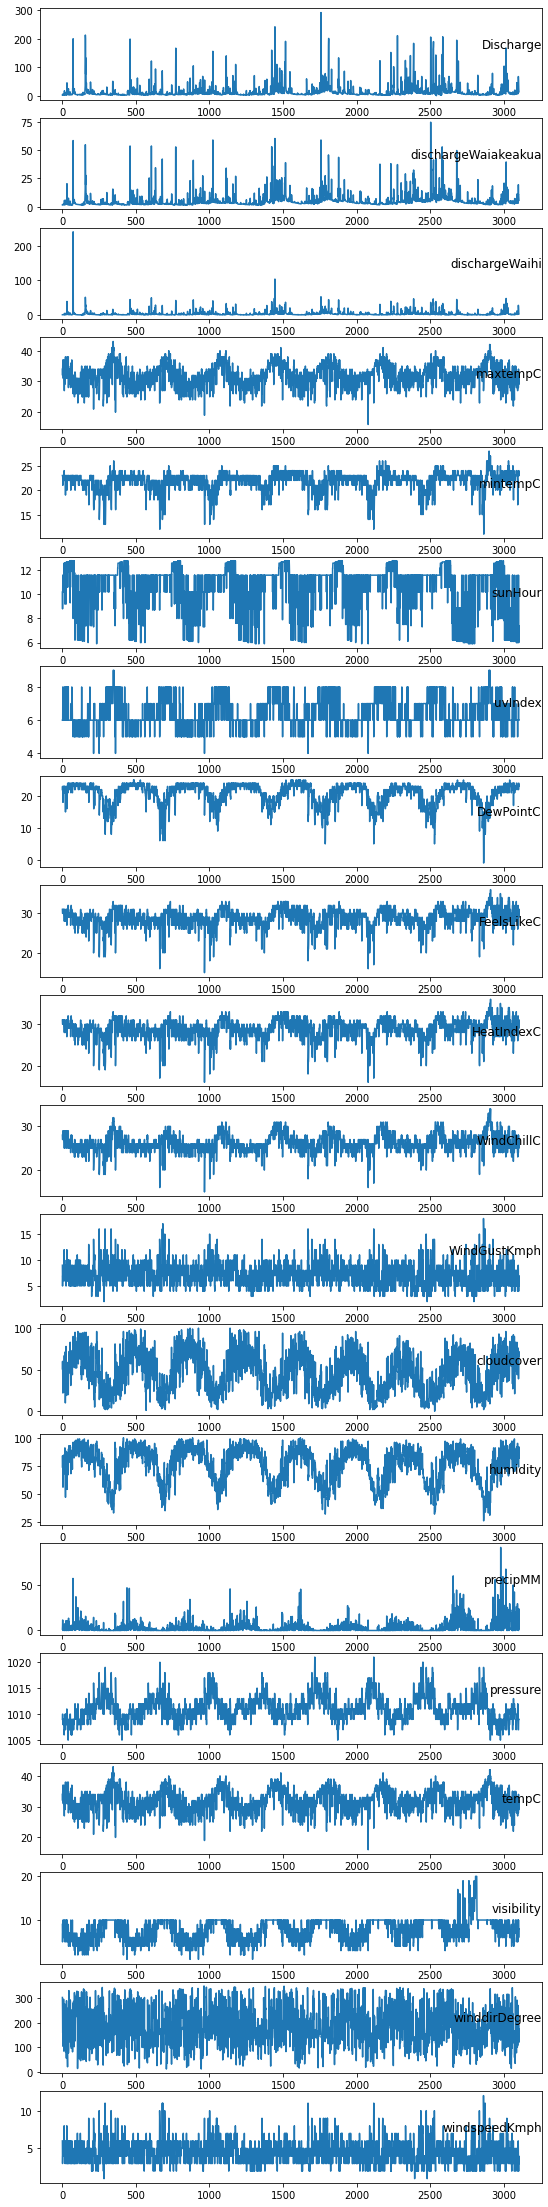

In [ ]:
# specify columns to plot
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
i=1
values = df.values
plt.figure(figsize=(9,40))
for variable in columns:
     plt.subplot(len(columns), 1, i)
     plt.plot(values[:, variable])
     plt.title(df.columns[variable], y=0.5, loc='right')
     i += 1
plt.show()

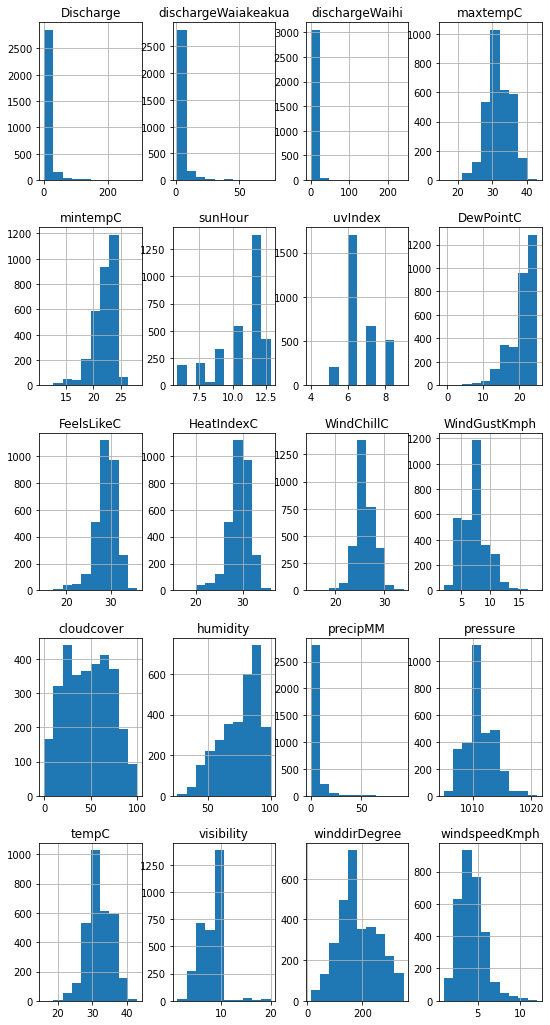

In [ ]:
# histogram
df.hist(figsize=(9,18))
plt.show()

In [ ]:
# outlier detection
up_b = df['Discharge'].mean() + 2*df['Discharge'].std()
low_b = df['Discharge'].mean() - 2*df['Discharge'].std()
df.loc[df['Discharge'] > up_b, 'Discharge'] = np.nan
df.loc[df['Discharge'] < low_b, 'Discharge'] = np.nan
df['Discharge'].interpolate(inplace=True)

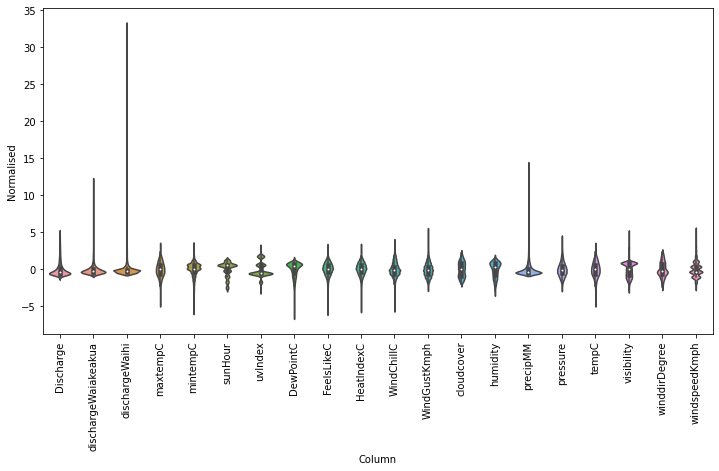

In [ ]:
# mean and standard deviation
mean = df.mean()
std = df.std()
# normalization
df_std = (df - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
values = df.values
# convert to floats
values = values.astype('float32')
# Normalization
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
print(scaled)

[[-0.7862999  -0.5692393  -0.36531028 ...  0.45670748  1.6487961
   1.0539341 ]
 [-0.7873535  -0.5692393  -0.3639238  ... -1.1488138   1.0070924
  -1.0415614 ]
 [-0.7757636  -0.5726697  -0.36531028 ... -0.3460532  -0.3600154
  -0.34306288]
 ...
 [ 2.9920309   0.9795789   1.2943339  ... -0.74743354 -0.6111168
  -1.7400599 ]
 [ 1.0322719   0.40155926  0.25307003 ...  0.05532715 -0.9040686
  -0.34306288]
 [ 0.3895554   0.10483107 -0.03809555 ...  0.05532715  0.04453692
  -1.0415614 ]]


In [ ]:
# lagging steps and features
backward_steps = 5
n_features = df.shape[1]

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(scaled, backward_steps, 1)

In [ ]:
# split into train and test sets
values = reframed.values
threshold = int(0.8 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]

# split into input and outputs
n_obs = backward_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], backward_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], backward_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2480, 100) 2480 (2480,)
(2480, 5, 20) (2480,) (620, 5, 20) (620,)


In [ ]:
# model Funnctions
# testing 

# create BiLSTM model
def create_model_bilstm(units):
  model = Sequential()
  model.add(Bidirectional(LSTM(units = units, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Bidirectional(LSTM(units = units)))
  model.add(Dense(1))
  #Compile model
  model.compile(optimizer='adam', loss='mae')
  return model

# create LSTM model
def create_model_lstm(units):
  model = Sequential()
  model.add(LSTM(units = units, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(units = units))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mae')
  return model

# create GRU model
def create_model_gru(units):
  model = Sequential()
  model.add(GRU(units = units, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  model.add(GRU(units = units))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mae')
  return model

# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model_gru(64)
model_lstm = create_model_lstm(64)

In [ ]:
# fit BiLSTM, LSTM and GRU
def fit_model(model):
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
  history = model.fit(train_X, train_y, epochs = 25, validation_split = 0.2, batch_size = 72, shuffle = False, callbacks = [early_stop])
  return history
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/25
28/28 [==============================] - 8s 84ms/step - loss: 0.5814 - val_loss: 0.5738
Epoch 2/25
28/28 [==============================] - 1s 20ms/step - loss: 0.4314 - val_loss: 0.5048
Epoch 3/25
28/28 [==============================] - 1s 22ms/step - loss: 0.3833 - val_loss: 0.4780
Epoch 4/25
28/28 [==============================] - 1s 21ms/step - loss: 0.3662 - val_loss: 0.4737
Epoch 5/25
28/28 [==============================] - 1s 20ms/step - loss: 0.3584 - val_loss: 0.4739
Epoch 6/25
28/28 [==============================] - 1s 20ms/step - loss: 0.3637 - val_loss: 0.4828
Epoch 7/25
28/28 [==============================] - 1s 20ms/step - loss: 0.3565 - val_loss: 0.4815
Epoch 8/25
28/28 [==============================] - 1s 20ms/step - loss: 0.3596 - val_loss: 0.4731
Epoch 9/25
28/28 [==============================] - 1s 20ms/step - loss: 0.3509 - val_loss: 0.4561
Epoch 10/25
28/28 [==============================] - 1s 20ms/step - loss: 0.3411 - val_loss: 0.4523
Epoch 11/

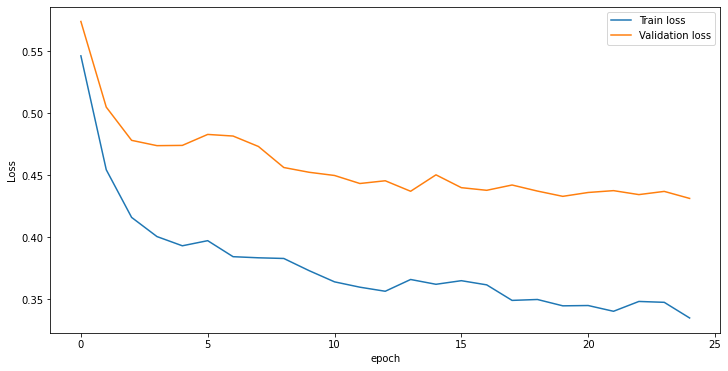

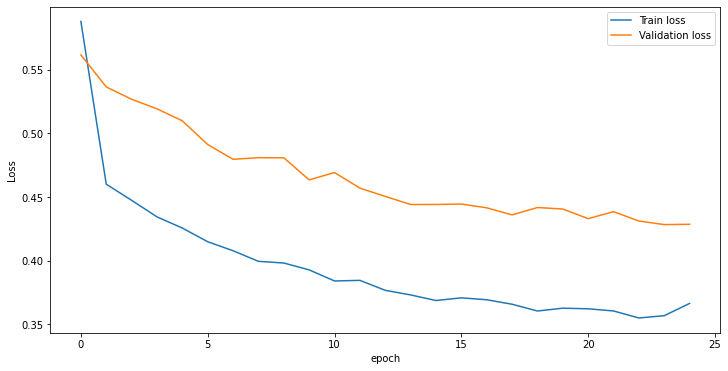

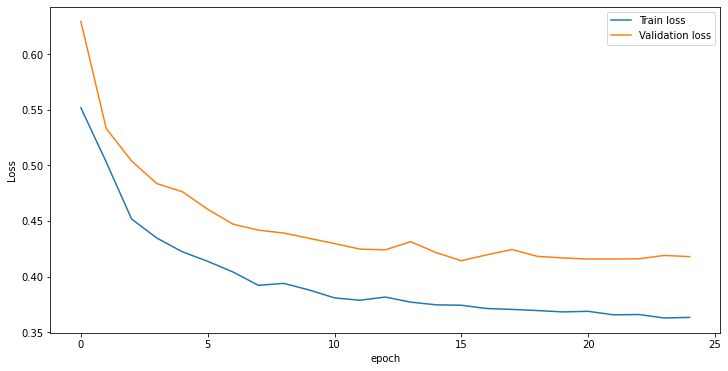

In [ ]:
# plot train loss and validation loss
def plot_loss (history, int):
  plt.figure(figsize = (12, 6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['Train loss', 'Validation loss'], loc='upper right')
  plt.savefig(f"lossgraphs{int}.jpg")
  plt.show()
plot_loss (history_bilstm, 1)
plot_loss (history_lstm, 2)
plot_loss (history_gru, 3)

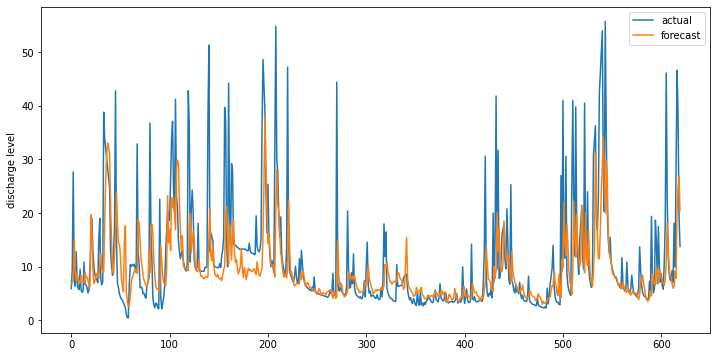

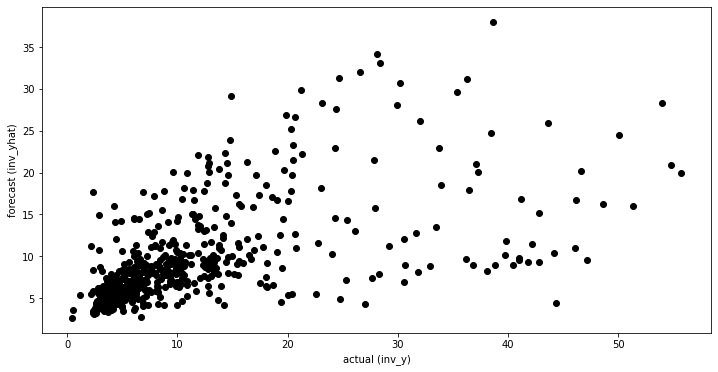

Test RMSE: 8.273


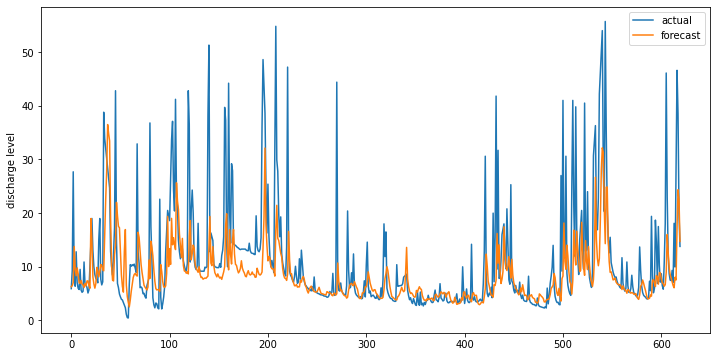

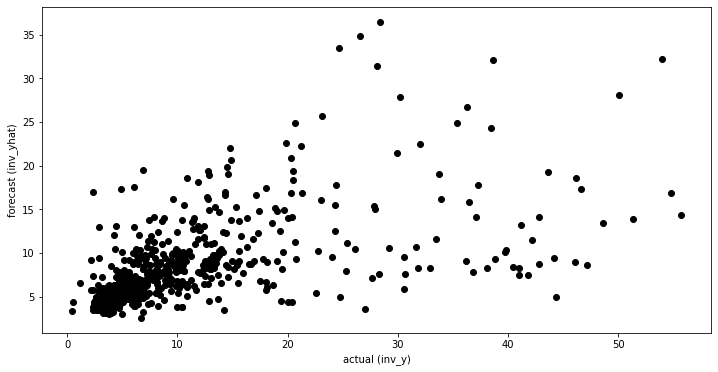

Test RMSE: 8.594


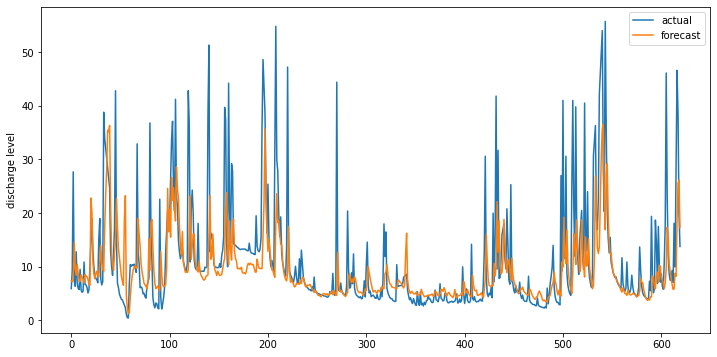

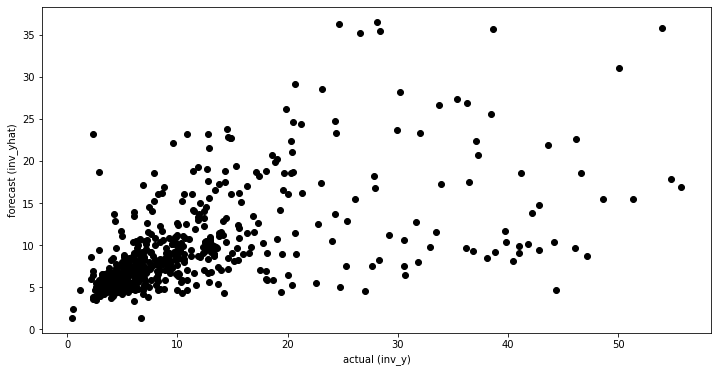

Test RMSE: 8.253


In [ ]:
# predictions
def prediction(model, test_X, test_y, int):
  # make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], backward_steps*n_features))
  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X[:, -(n_features - 1):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X[:, -(n_features - 1):]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  # Prediction Plots
  plt.figure(figsize=(12, 6))
  plt.plot(inv_y, label='actual')
  plt.plot(inv_yhat, label='forecast')
  plt.ylabel('discharge level')
  plt.legend()
  plt.savefig(f"actual-forecastplot{int}.jpg")
  plt.show()
  # Scatter plot
  plt.figure(figsize=(12, 6))
  plt.plot(inv_y, inv_yhat, 'o', color='black');
  plt.ylabel('forecast (inv_yhat)')
  plt.xlabel('actual (inv_y)')
  plt.savefig(f"scatterplot{int}.jpg")
  plt.show()
  # calculate RMSE
  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)
  return inv_y, inv_yhat
prediction_bilstm = prediction(model_bilstm, test_X, test_y, 1)
prediction_lstm = prediction(model_lstm, test_X, test_y, 2)
prediction_gru = prediction(model_gru, test_X, test_y, 3)